In [41]:
import csv
file = open("eloList.csv","r")
dataList = list(csv.reader(file,delimiter=','))
file.close()

for i in range(len(dataList)):
    dataList[i][2] = dataList[i][2].replace('{subdomain}','t0')
    dataList[i][2] = dataList[i][2].replace('{faceId}{tileId}','10')

from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes, Details
from msrest.authentication import CognitiveServicesCredentials
from array import array
import os
from PIL import Image
import sys
import time
from tqdm import tqdm
import random
subscription_key = "b97befa0b6594e009f054310a2bb6caf"
endpoint = "https://computervision101.cognitiveservices.azure.com/"


computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))
remote_image_features = [VisualFeatureTypes.categories,VisualFeatureTypes.brands,VisualFeatureTypes.adult,VisualFeatureTypes.color,VisualFeatureTypes.description,VisualFeatureTypes.faces,VisualFeatureTypes.image_type,VisualFeatureTypes.objects,VisualFeatureTypes.tags]
remote_image_details = [Details.landmarks]

images_list = []
for i in range(0,len(dataList)):
    dataList[i][1]=float(dataList[i][1])
    images_list.append(dataList[i][2])


img_details = []

def colour(results_remote):
    dom_bg = results_remote.color.dominant_color_background
    dom_fg = results_remote.color.dominant_color_foreground
    dom = results_remote.color.dominant_colors
    if len(dom) == 0:
        if dom_bg != dom_fg:
            dom = [dom_fg, dom_bg]
        else:
            dom = [dom_fg]
    return dom, dom_bg, dom_fg


def object(results_remote):
    obj = []
    if len(results_remote.objects) == 0:
        pass
    else:
        for object in results_remote.objects:
            if object.confidence > 0.5:
                obj.append(object.object_property)
    return obj

def details(images_list):
    for i,image in enumerate(tqdm(images_list)):
        img_results = computervision_client.analyze_image(image, remote_image_features, remote_image_details)
        dom, dom_bg, dom_fg = colour(img_results)
        obj = object(img_results)
        img_details.append({'dominant_colours':dom,'dominant_fg_colour':dom_fg,'dominant_bg_colour':dom_bg,'object':obj})
    return img_details

img_details=details(images_list)


100%|██████████| 2000/2000 [17:23<00:00,  1.92it/s]


[['Grey', 1041], ['Black', 712], ['White', 573], ['Brown', 77], ['Blue', 196], ['Pink', 13], ['Green', 93], ['Yellow', 10], ['Red', 2], ['Purple', 3]]


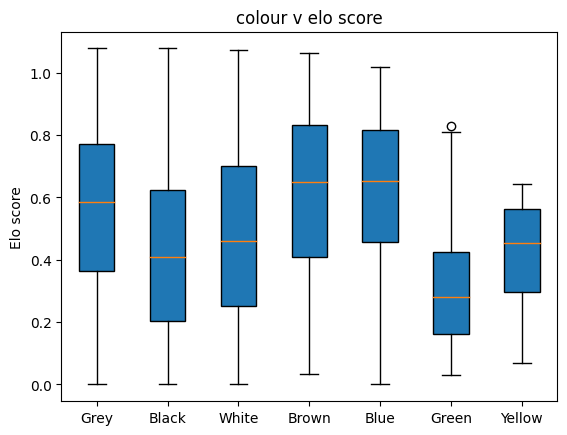

In [101]:
import matplotlib.pyplot as plt

colours = []
coloursUsed = []
for i in range(len(img_details)):
    colour=img_details[i]['dominant_colours']
    for j in range(len(colour)):
        if colour[j] not in coloursUsed:
            colours.append([colour[j],1])
            coloursUsed.append(colour[j])
        else:
            for k in range(len(colours)):
                if colour[j] == colours[k][0]:
                    colours[k][1]+=1
colourData = []
for i in range(len(img_details)):
    colour=img_details[i]['dominant_colours']
    for j in range(len(colour)):
        colourData.append([dataList[i][1],colour[j]])

col_dict = {}
for i,col in enumerate(colours):
    col_dict[col[0]] = []

for elo_score,colour in colourData:
    col_dict[colour].append(elo_score)

print(colours)

col_dict = {k:v for k,v in col_dict.items() if k not in ['Pink','Red','Purple']}
box_plot_data=col_dict.values()
plt.title("colour v elo score")
plt.boxplot(box_plot_data,patch_artist=True,labels=col_dict.keys())
plt.ylabel("Elo score")
plt.show()

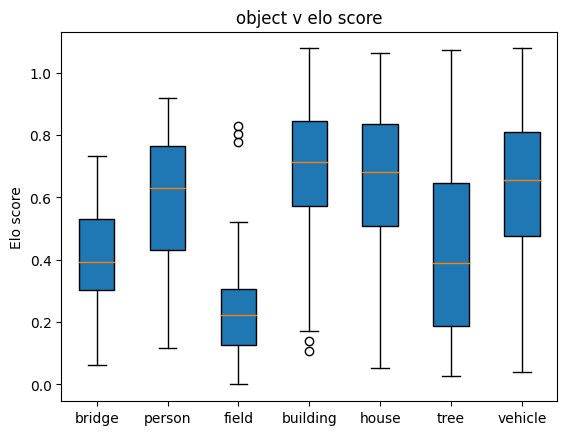

In [100]:
import matplotlib.pyplot as plt
objects = []
objectsUsed = []
for i in range(len(img_details)):
    object=info[i]['object']
    for j in range(len(object)):
        if object[j] in ['Vehicle','Land vehicle','Van','truck','taxi','car','motorcycle','Limousine','shuttle bus']:
            object[j] = 'vehicle'
        if object[j] in ['hall','room','window','dormer window']:
            object[j] = 'house'
        if object[j] in ['shop','castle','rural_building']:
            object[j] = 'building'
        if object[j] in ['land','fence','rail fence']:
            object[j] = 'field'
        if object[j] in ['plant','maple','olive tree','american arborvitae tree','Maple','palm tree']:
            object[j] = 'tree'
        if object[j] == 'steppe':
            object[j] = 'land'
        if object[j] not in objectsUsed:
            objects.append([object[j],1])
            objectsUsed.append(object[j])
        else:
            for k in range(len(objects)):
                if object[j] == objects[k][0]:
                    objects[k][1]+=1

objectData = []

for i in range(len(img_details)):
    object=img_details[i]['object']
    for j in range(len(object)):
        objectData.append([dataList[i][1],object[j]])

objects.sort(key=lambda x: x[1])

obj_dict = {}
for i,obj in enumerate(objects):
    obj_dict[obj[0]] = []

for elo_score,object in objectData:
    obj_dict[object].append(elo_score)

obj_dict = {k:v for k,v in obj_dict.items() if k in ['field','tree','bridge','person','building','vehicle','house']}
box_plot_data=obj_dict.values()
plt.title("object v elo score")
plt.boxplot(box_plot_data,patch_artist=True,labels=obj_dict.keys())
plt.ylabel("Elo score")
plt.show()



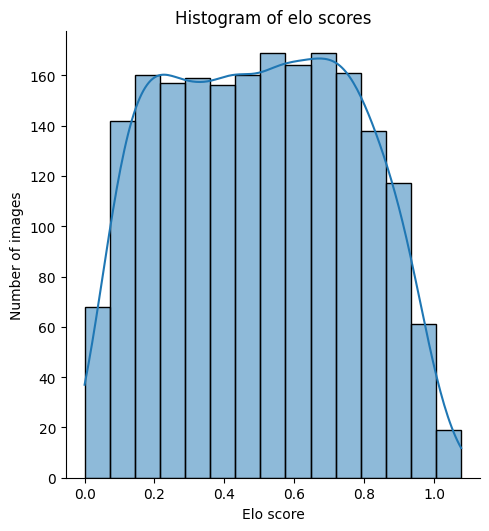

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
x = []
for i in range(len(dataList)):
    x.append(dataList[i][1])

x = np.asarray(x)
q25, q75 = np.percentile(x, [25, 75])
bin_width = 2 * (q75 - q25) * len(x) ** (-1/3)
bins = round((x.max() - x.min()) / bin_width)
sns.displot(x, bins=bins, kde=True)
plt.ylabel("Number of images")
plt.xlabel("Elo score")
plt.title("Histogram of elo scores")
plt.show()

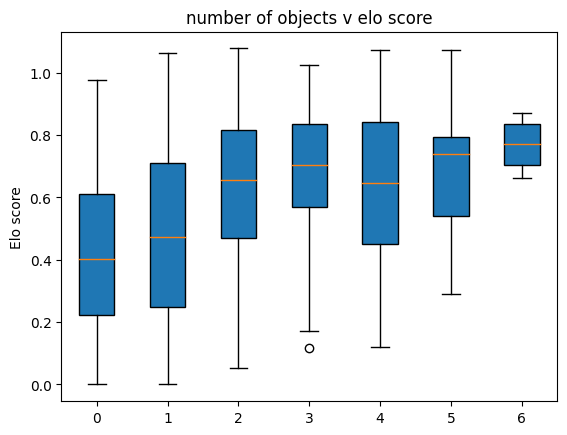

In [104]:
x = []
y = []
max = 0

for i in range(len(img_details)):
    object_no = len(img_details[i]['object'])
    x.append(object_no)
    y.append(dataList[i][1])
#working out how many df categories needed for box plot - ended up being 6
    if object_no>max:
        max = object_no
    
obj_no_dict = {}
for i,val in enumerate(x):
    obj_no_dict[val] = []

obj_no_dict = dict(sorted(obj_no_dict.items()))

for i,objectNo in enumerate(x):
    obj_no_dict[objectNo].append(y[i])

box_plot_data=obj_no_dict.values()
plt.title("number of objects v elo score")
plt.boxplot(box_plot_data,patch_artist=True,labels=obj_no_dict.keys())
plt.ylabel("Elo score")
plt.show()

In [105]:
#making one large dictionary that contains all information about images (excluding url)
for i in range(len(dataList)):
    img_details[i]['id'] = int(dataList[i][0])
    img_details[i]['elo_score'] = dataList[i][1]
    img_details[i]['url'] = dataList[i][2]


In [103]:
#putting elo scores into bins (always <= lower value and < higher value)
bin1 = []
bin2 = []
bin3 = []
bin4 = []
bin5 = []
bin6 = []

bins_dict = {}
for i in range(1,7):
    key = f'bin{i}'
    bins_dict[key] = []

print(bins_dict)

def order(min,max,image,bin_list):
    num = image['elo_score']
    if min <= num < max:
        bin_list.append(image)

elo_scores = y
for i,img in enumerate(elo_scores)

obj_no_dict = {}
for i,val in enumerate(x):
    obj_no_dict[val] = []

obj_no_dict = dict(sorted(obj_no_dict.items()))

for i,objectNo in enumerate(x):
    obj_no_dict[objectNo].append(y[i])

box_plot_data=obj_no_dict.values()
plt.title("number of objects v elo score")
plt.boxplot(box_plot_data,patch_artist=True,labels=obj_no_dict.keys())
plt.ylabel("Elo score")
plt.show()

for i in range(len(images_info)):
    img = images_info[i]
    order(0,0.2,img,bin1)
    order(0.2,0.4,img,bin2)
    order(0.4,0.6,img,bin3)
    order(0.6,0.8,img,bin4)
    order(0.8,1,img,bin5)
    order(1,1.2,img,bin6)

print('''
bin 1 (0 - 0.2) = %s
bin 2 (0.2 - 0.4) = %s
bin 3 (0.4 - 0.6) = %s
bin 4 (0.6 - 0.8) = %s
bin 5 (0.8 - 1) = %s
bin 6 ( >1 ) = %s
'''%(len(bin1),len(bin2),len(bin3),len(bin4),len(bin5),len(bin6)))

{'bin1': [], 'bin2': [], 'bin3': [], 'bin4': [], 'bin5': [], 'bin6': []}

bin 1 (0 - 0.2) = 326
bin 2 (0.2 - 0.4) = 443
bin 3 (0.4 - 0.6) = 455
bin 4 (0.6 - 0.8) = 458
bin 5 (0.8 - 1) = 299
bin 6 ( >1 ) = 19



In [40]:
#outputting three random images per bin
import urllib.request
from PIL import Image
from IPython import display
from skimage import io
import random

def printImages(bin):
    img1 = random.randint(0,len(bin))
    img2 = random.randint(0,len(bin))
    img3 = random.randint(0,len(bin))
#sampling without replacement - not putting element into list so not sampled again
#random.shuffle on list of integers and pick first three
    while True:
        if img1 == img2:
            img2 = random.randint(0,len(bin))
        else:
            break
    while True:
        if img3 == img2 or img3 == img1:
            img3 = random.randint(0,len(bin))
        else:
            break
    
    imgList = []
    imgList.append(img1)
    imgList.append(img2)
    imgList.append(img3)

    for i in range(len(imgList)):
        urllib.request.urlretrieve(bin[imgList[i]]['url'], 'img.png')
        img = Image.open('img.png')
        img.show()

printImages(bin1)
printImages(bin2)
printImages(bin3)
printImages(bin4)
printImages(bin5)
printImages(bin6)

In [51]:
#printing out most common colour per bin
    
def commonColour(bin):
#creating a list of colours and how many images have that colour as their dominant colour in form ['colour',*number of images*]
    colours = []
    coloursUsed = []
    for i in range(len(bin)):
        colour=bin[i]['dominant_colours']
        for j in range(len(colour)):
            if colour[j] not in coloursUsed:
                colours.append([colour[j],1])
                coloursUsed.append(colour[j])
            else:
                for k in range(len(colours)):
                    if colour[j] == colours[k][0]:
                        colours[k][1]+=1
    print(colours)
#calculating the most common colour per bin using the colours list created above
    common_colour = ['',0]
    for i in range(len(colours)):
        if colours[i][1] > common_colour[1]:
            common_colour = colours[i]
        elif colours[i][1] == common_colour[1]:
            common_colour[0] += ', '
            common_colour[0] += colours[i][0]
    return common_colour[0]

#dictionary key - bin, value - cc colour
cc_bin1 = commonColour(bin1)
cc_bin2 = commonColour(bin2)
cc_bin3 = commonColour(bin3)
cc_bin4 = commonColour(bin4)
cc_bin5 = commonColour(bin5)
cc_bin6 = commonColour(bin6)

print('''
bin 1 (0 - 0.2) = %s
bin 2 (0.2 - 0.4) = %s
bin 3 (0.4 - 0.6) = %s
bin 4 (0.6 - 0.8) = %s
bin 5 (0.8 - 1) = %s
bin 6 ( >1 ) = %s
'''%(cc_bin1,cc_bin2,cc_bin3,cc_bin4,cc_bin5,cc_bin6))

[['Grey', 113], ['Black', 171], ['White', 98], ['Green', 35], ['Yellow', 2], ['Blue', 12], ['Brown', 4]]
[['Black', 176], ['Grey', 188], ['White', 142], ['Green', 29], ['Brown', 15], ['Pink', 5], ['Blue', 25], ['Purple', 2], ['Yellow', 1]]
[['Brown', 17], ['Grey', 234], ['Black', 166], ['White', 134], ['Blue', 41], ['Red', 2], ['Yellow', 6], ['Pink', 3], ['Green', 21], ['Purple', 1]]
[['White', 119], ['Black', 137], ['Grey', 280], ['Brown', 17], ['Blue', 63], ['Green', 6], ['Pink', 3], ['Yellow', 1]]
[['Black', 59], ['White', 76], ['Grey', 208], ['Blue', 51], ['Brown', 23], ['Pink', 2], ['Green', 2]]
[['Grey', 18], ['Black', 3], ['White', 4], ['Brown', 1], ['Blue', 4]]

bin 1 (0 - 0.2) = Black
bin 2 (0.2 - 0.4) = Grey
bin 3 (0.4 - 0.6) = Grey
bin 4 (0.6 - 0.8) = Grey
bin 5 (0.8 - 1) = Grey
bin 6 ( >1 ) = Grey



In [59]:
#printing out 3 most common objects per bin
    
def commonObjects(bin):
#creating a list of objects and how many images have that object in form ['object',*number of images*]
    objects = []
    objectsUsed = []
    for i in range(len(bin)):
        object=bin[i]['object']
        for j in range(len(object)):
            if object[j] == 'Vehicle' or object[j] == 'Land vehicle' or object[j]== 'Van'or object[j]== 'truck'or object[j]== 'taxi' or object[j]=='car' or object[j]=='motorcycle' or object[j]=='Limousine' or object[j] == 'shuttle bus':
                object[j] = 'vehicle'
            if object[j] == 'hall' or object[j] == 'room' or object[j] == 'window' or object[j] == 'dormer window':
                object[j] = 'house'
            if object[j] == 'land' or object[j] == 'fence' or object[j] == 'rail fence':
                object[j] = 'field'
            if object[j] == 'plant' or object[j] == 'maple' or object[j] == 'olive tree' or object[j] =='american arborvitae tree':
                object[j] = 'tree'
            if object[j] == 'steppe':
                object[j] = 'land'
            if object[j] == 'Castle':
                object[j] = 'rural_building'
            if object[j] not in objectsUsed:
                objects.append([object[j],1])
                objectsUsed.append(object[j])
            else:
                for k in range(len(objects)):
                    if object[j] == objects[k][0]:
                        objects[k][1]+=1
    # print(objects)
#calculating the most common colour per bin using the colours list created above
    common_object1 = ['',0]
    common_object2 = ['',0]
    common_object3 = ['',0]
    # def sortCommonObjects(num,list):
    # sortCommonObjects
    for i in range(len(objects)):
        if objects[i][1] > common_object1[1]:
            common_object2 = common_object1
            common_object1 = objects[i]
        elif objects[i][1] == common_object1[1]:
            common_object1[0] += ', '
            common_object1[0] += objects[i][0]
        elif common_object2[1] < objects[i][1] < common_object1[1]:
            common_object3 = common_object2
            common_object2 = objects[i]
        elif objects[i][1] == common_object2[1]:
            common_object2[0] += ', '
            common_object2[0] += objects[i][0]
        elif common_object3[1] < objects[i][1] < common_object2[1]:
            common_object3 = objects[i]
        elif objects[i][1] == common_object3[1]:
            common_object2[0] += ', '
            common_object2[0] += objects[i][0]
    #     print('i = %s, 1 = %s, 2 = %s, 3 = %s'%(i,common_object1,
    # common_object2,
    # common_object3))
    return common_object1[0],common_object2[0],common_object3[0]

#co1 stands for common object 1, co2 etc...
co1_bin1,co2_bin1,co3_bin1 = commonObjects(bin1)
co1_bin2,co2_bin2,co3_bin2 = commonObjects(bin2)
co1_bin3,co2_bin3,co3_bin3 = commonObjects(bin3)
co1_bin4,co2_bin4,co3_bin4 = commonObjects(bin4)
co1_bin5,co2_bin5,co3_bin5 = commonObjects(bin5)
co1_bin6,co2_bin6,co3_bin6 = commonObjects(bin6)

print('''
bin 1 (0 - 0.2) = %s, %s, %s
bin 2 (0.2 - 0.4) = %s, %s, %s
bin 3 (0.4 - 0.6) = %s, %s, %s
bin 4 (0.6 - 0.8) = %s, %s, %s
bin 5 (0.8 - 1) = %s, %s, %s
bin 6 ( >1 ) = %s, %s, %s
'''%
(co1_bin1,co2_bin1,co3_bin1,
co1_bin2,co2_bin2,co3_bin2,
co1_bin3,co2_bin3,co3_bin3,
co1_bin4,co2_bin4,co3_bin4,
co1_bin5,co2_bin5,co3_bin5,
co1_bin6,co2_bin6,co3_bin6))

[['tree', 80], ['field', 54], ['vehicle', 36], ['building', 5], ['house', 4], ['airplane', 1], ['tile roof', 1], ['bullet', 1], ['bridge', 3], ['Luggage and bags', 1], ['person', 2], ['bicycle', 1], ['suede fiber', 1], ['weeping willow', 1], ['grainfield', 1], ['fabric', 1]]
[['tree', 72], ['bridge', 5], ['house', 26], ['vehicle', 142], ['field', 49], ['building', 12], ['person', 3], ['stop sign', 1], ['araucaria tree', 1], ['picket fence', 2]]
[['building', 29], ['vehicle', 263], ['person', 4], ['bicycle', 1], ['tree', 61], ['house', 48], ['Watercraft', 2], ['bridge', 3], ['skyscraper', 1], ['field', 15], ['race car', 1], ['boat', 1], ['mammal', 2], ['stop sign', 1]]
[['vehicle', 357], ['tree', 46], ['house', 75], ['field', 5], ['building', 49], ['person', 7], ['bridge', 3], ['palm tree', 1], ['tower', 1]]
[['vehicle', 271], ['field', 4], ['building', 45], ['house', 66], ['tree', 34], ['Maple', 1], ['shop', 2], ['person', 4], ['palm tree', 1], ['cycle', 1], ['weapon', 1]]
[['vehicle',

conclusion
- limitations
- 